## <b> Modelling HDB Resale Prices </b>
---
### <b> Notebook 3: Data Analysis </b>
---

<b> Project Overview / Objectives </b>

* Build a model that predicts the resale price of public housing (i.e., Housing Development Board (HDB)) apartments in Singapore
    * Evaluate the model's predictive ability against unseen "test" data, via a Kaggle submission
* Separably identify key features associated with resale prices - by quantifying their importance from a statistical and practical viewpoint

<br>
<b> Notebook Overview </b>

* The codes in this notebook perform two broad categories of data analysis:  
    * <b>Inference</b>: for identifying features strongly associated with resale prices, by assessing their statistical and practical significance
    * <b>Prediction</b>: for building a model that predicts resale prices well, while evaluating if regularisation techniques should be incorporated to improve the predictive model's generalisability
    
<br>
<b> Notebook Structure </b>

* Part 1: Import & Prepare Data for Analysis
* Part 2: Inference :: Unregularised OLS Regression Analysis
* Part 3: Prediction :: Unregularised & Regularised OLS Regression Analysis
* Part 4: Model Finalisation, Prepare Dataset for Kaggle Submission
* Part 5: Discussion / Suggestions for Further Research

<br>


---

<b>Imports & Installations</b>

In [37]:
# Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, r2_score


---

#### <b> Part 1: Import & Prepare Data for Analysis </b>

<b>Background</b>

There exists two versions of each the 3 mutually exclusive processed datasets ("df_train", "df_test_sim", "df_test"): 

|Dataset Description|X(Numeric) Features|Dataset Suffix|Purpose                                                                                                                     |
|-------------------|-------------------|--------------|----------------------------------------------------------------------------------------------------------------------------|
|Processed          |Unscaled           |"_p"          |For identifying features that are significantly associated with resale price (practically and statistically)                |
|Processed          |Scaled             |"_ps"         |For building a model that predicts resale prices well, while evaluating if regularisation techniques should be incorporated |

The codes in this section separate the datasets into their X and y components for subsequent analysis.

<br>
<b>Import & Prepare Data for Analysis</b>

In [38]:
# 1. Define Dictionary of Dataset Names
data_dict = {"df_train_p":["X_train_p", "y_train_p"],
             "df_train_ps":["X_train_ps", "y_train_ps"],
             "df_test_sim_p":["X_test_sim_p", "y_test_sim_p"],
             "df_test_sim_ps":["X_test_sim_ps", "y_test_sim_ps"],
             "df_test_p":["X_test_p"],
             "df_test_ps":["X_test_ps"]             
             }

# 2. Import & Split Datasets into 'X' and 'y' Components  
for df_name, df_list_elements in data_dict.items():

    # Data: Import 
    dataframe = pd.read_csv(f"1_Data\{df_name}.csv")
    globals()[f"{df_name}"] = dataframe.copy()

    # Data: Split
    try: 
        X_features = [feature for feature in dataframe.columns]
        X_features.remove("resale_price")
        X_features.remove("id")
        
        y = "resale_price"

        globals()[df_list_elements[0]] = dataframe[X_features]
        globals()[df_list_elements[1]] = dataframe[y]
    
    except: # considering absence of 'y' features in "df_test_p" and "df_test_ps" 
        globals()[df_list_elements[0]] = dataframe.copy()



---

#### <b> Part 2: Inference :: Unregularised OLS Regression Analysis </b>

<b>Background: Employing Unregularised Regression</b>

* <u>Unregularised</u> OLS regression analysis will be performed to <u>identify features strongly associated with resale price</u> (from a statistical and practical standpoint)

* Regularisation (ridge/lasso) will <u>not</u> be utilised as these methods produce biased coefficient estimates that pose complications in the context of statistical inference. The production of biased coefficients stem from: 
    * Regularisation inherently biasing coefficient estimates towards zero (i.e., accepting greater model bias in exchange for lower variance - with the view towards increasing a model's generalisability in a prediction context) [1]
    * Risk of introducing omitted variable bias (OVB) when lasso regularisation is employed [2]
        * While the approach can aid with feature selection (as it allows coefficient shrinkage to reach zero) - features that are subsequently dropped (i.e., features with coefficient estimates = zero) may be associated with the remaining feature(s) and outcome, resulting in the remaining feature(s)' coefficients being affected by OVB 
        * While OVB is not a concern in the context of prediction, it is the context of inference - as OVB can lead to over/underestimation of a coefficient's magnitude
        
<br>
<b>Background: Addressing Multicollinearity Concerns</b>

* Multicollinearity results in unstable coefficient estimates, inflates their standard errors and thus   increases the likelihood of misjudging features as statistically insignificant.
* To address this concern, multicollinearity's presence will be tested for by computing features' Variance Inflation Factors (VIFs), and comparing them against a benchmark of VIF<10 (indicating an absence of multicollinearity). [3]

<br>References
* [1] Clark et al. (2022). What Makes a Satisfying Life - Prediction & Interpretation with Machine-Learning Algorithms. London School of Economics & Political Science - Center for Economic Performance. [(Link)](https://eprints.lse.ac.uk/117887/1/dp1853.pdf)
* [2] Wuthrich & Zhu (2023). Omitted Variable Bias of Lasso-based Inference Methods - A Finite Sample Analysis. Review of Economics & Statistics. [(Link)](https://arxiv.org/pdf/1903.08704.pdf)
* [3] University of California Los Angeles (UCLA) (2021). Regression with STATA Chapter 2 - Regression Diagnostics. [(Link)](https://stats.oarc.ucla.edu/stata/webbooks/reg/chapter2/stata-webbooksregressionwith-statachapter-2-regression-diagnostics/)

<br>


---

<b>(a) Inference: Unregularised OLS Regression Analysis</b>

* The analysis will be applied on unscaled "training" data
    * Unscaled: to aid with interpretation of features' coefficient estimates
* In addition, heteroskedasticity-robust standard errors will be specified
    * To address to incorrect ascription/non-ascription of statistical significance, as standard errors are biased under heteroskedasticity [(Link)](https://link.springer.com/content/pdf/10.3758/BF03192961.pdf)

<br>
<b> Run Unregularised OLS Regression Analysis (w StatsModels)</b>

In [39]:
# 1. Specify X and y Variables
X = X_train_p
X = sm.add_constant(X)
y = y_train_p

# 2. Run Unregularised OLS Regression
ols_unregularised = sm.OLS(y, X).fit(cov_type="HC3")  # HC3: heteroskedasticity-robust standard errors
ols_unregularised.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     9484.
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:29:45   Log-Likelihood:            -1.3463e+06
No. Observations:              110318   AIC:                         2.693e+06
Df Residuals:                  110255   BIC:                         2.693e+06
Df Model:                          62                                         
Covariance Type:                  HC3                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -1.858e+05   9816.471    -18.929      0.000   -2.05e+05   -1.67e+05
floor_area_sqm                      3469.7877     59.345     58.468      0.000    3353.474    3586.101
floor_area_sqm_2                       3.1898      0.302     10.566      0.000       2.598       3.781
floor_level_mid                     3740.9399     84.986     44.018      0.000    3574.370    3907.510
floor_level_mid_2                     23.3003      3.842      6.065      0.000      15.771      30.830
flat_type_dbss                      1.298e+05   1922.543     67.521      0.000    1.26e+05    1.34e+05
flat_type_terrace                   3.897e+05   1.02e+04     38.043      0.000     3.7e+05     4.1e+05
flat_type_maisonette_loft           4.389e+04   1340.193     32.752      0.000    4.13e+04    4.65e+04
flat_type_duxton_s1_s2              1.706e+05   5000.686     34.121      0.000    1.61e+05     1.8e+05
remaining_lease_years               4287.8570    240.763     17.809      0.000    3815.970    4759.744
remaining_lease_years_2                1.5187      1.546      0.982      0.326      -1.512       4.549
blk_rental_present                 -1.142e+04    972.305    -11.750      0.000   -1.33e+04   -9519.159
mrt_nearest_frm000_500              5.927e+04    461.472    128.441      0.000    5.84e+04    6.02e+04
mrt_nearest_abv500_1000             2.985e+04    402.481     74.165      0.000    2.91e+04    3.06e+04
mrt_nearest_interchange_train_bus   8126.7946    551.850     14.726      0.000    7045.188    9208.401
mrt_nearest_interchange_train_only  1.126e+04   1262.359      8.924      0.000    8790.622    1.37e+04
mrt_nearest_interchange_bus_only    1.199e+04    503.982     23.798      0.000     1.1e+04     1.3e+04
bus_stop_nearest_frm000_150          608.9471    357.749      1.702      0.089     -92.227    1310.121
mall_nearest_frm000_500             8816.1562    601.404     14.659      0.000    7637.425    9994.887
mall_nearest_abv500_1000            4430.9252    531.108      8.343      0.000    3389.973    5471.877
hawker_nearest_frm000_500           1.943e+04    576.224     33.722      0.000    1.83e+04    2.06e+04
hawker_nearest_abv500_1000          7074.3009    466.484     15.165      0.000    6160.009    7988.593
hawker_nearest_size_large           1.519e+04    514.934     29.495      0.000    1.42e+04    1.62e+04
mrt_travel_cost_cbd                -1.446e+04    723.920    -19.978      0.000   -1.59e+04    -1.3e+04
mrt_travel_cost_cbd_2                156.8455     34.368      4.564      0.000      89.486     224.205
n_brand_pri_sch_within_0-1km        5292.1945    355.536     14.885      0.000    4595.356    5989.033
n_brand_pri_sch_within_1-2km        3746.1019    228.585     16.388      0.000    3298.084    41

<b>Visualise Regression Results</b>

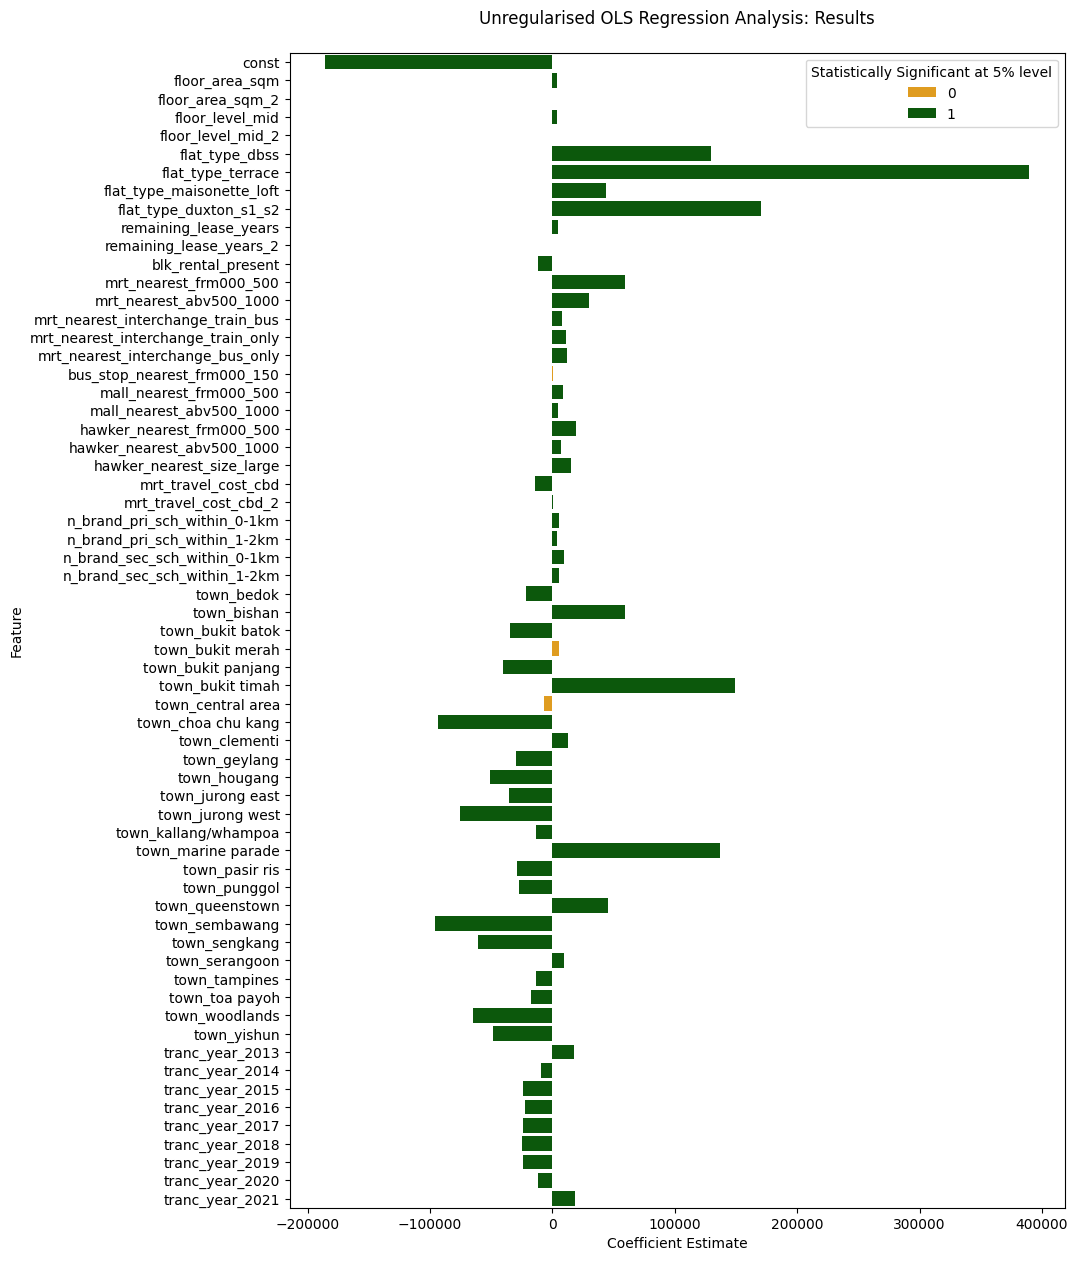

In [40]:
# Visualise Regression Results

# 1. Create Dataframe: Coefficient Estimates, p-values 
ols_results = {"coefficient": round(ols_unregularised.params),
               "p_value": ols_unregularised.pvalues}

ols_results = pd.DataFrame(ols_results)

ols_results.reset_index(inplace=True)
ols_results.rename(columns={"index":"feature"}, inplace=True)

ols_results["stat_sig_005"] = (ols_results["p_value"]<=0.05).astype(int)

# 2. Plot Horizontal Bar Chart
plt.figure(figsize=(10,15))
plt.title("Unregularised OLS Regression Analysis: Results\n")

palette = {0:"orange", 1:"darkgreen"}
sns.barplot(x=ols_results["coefficient"], y=ols_results["feature"], orient="h", hue=ols_results["stat_sig_005"], palette=palette)

plt.ylabel("Feature")
plt.xlabel("Coefficient Estimate")

plt.legend(title="Statistically Significant at 5% level")



---
<b>(b) Multicollinearity Check: Variance Inflation Factor (VIF) Analysis</b>

In [41]:
# Display Model VIFs

# 1. Instantiate & Update Dataframe: VIF Values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 

# 2. Display VIF Values
for i in vif_data.itertuples():
    print(f"Feature: {i[1]} :: VIF = {round(i[2],2)}")


Feature: const :: VIF = 3380.09
Feature: floor_area_sqm :: VIF = 79.75
Feature: floor_area_sqm_2 :: VIF = 79.82
Feature: floor_level_mid :: VIF = 6.49
Feature: floor_level_mid_2 :: VIF = 6.95
Feature: flat_type_dbss :: VIF = 1.2
Feature: flat_type_terrace :: VIF = 1.03
Feature: flat_type_maisonette_loft :: VIF = 1.57
Feature: flat_type_duxton_s1_s2 :: VIF = 1.75
Feature: remaining_lease_years :: VIF = 287.44
Feature: remaining_lease_years_2 :: VIF = 280.52
Feature: blk_rental_present :: VIF = 1.24
Feature: mrt_nearest_frm000_500 :: VIF = 2.12
Feature: mrt_nearest_abv500_1000 :: VIF = 1.98
Feature: mrt_nearest_interchange_train_bus :: VIF = 2.82
Feature: mrt_nearest_interchange_train_only :: VIF = 1.32
Feature: mrt_nearest_interchange_bus_only :: VIF = 2.63
Feature: bus_stop_nearest_frm000_150 :: VIF = 1.03
Feature: mall_nearest_frm000_500 :: VIF = 3.27
Feature: mall_nearest_abv500_1000 :: VIF = 2.77
Feature: hawker_nearest_frm000_500 :: VIF = 3.31
Feature: hawker_nearest_abv500_1000 ::


---
 
<b>(c) Summary Statistics</b>



In [42]:
# Display Summary Statistics

df_train = pd.concat([y, X], axis=1)

print("== Summary Statistics: (Mean, Min, Max) ==\n")
for col in df_train.columns:
    print(f'{col}: {round(df_train[col].mean(),3)}, {round(df_train[col].min(),2)}, {round(df_train[col].max(),2)}')


== Summary Statistics: (Mean, Min, Max) ==

resale_price: 449775.359, 150000.0, 1258000.0
const: 1.0, 1.0, 1.0
floor_area_sqm: 97.369, 31.0, 171.0
floor_area_sqm_2: 10058.222, 961.0, 29241.0
floor_level_mid: 8.328, 2, 50
floor_level_mid_2: 99.671, 4, 2500
flat_type_dbss: 0.011, 0, 1
flat_type_terrace: 0.001, 0, 1
flat_type_maisonette_loft: 0.032, 0, 1
flat_type_duxton_s1_s2: 0.003, 0, 1
remaining_lease_years: 75.211, 45, 98
remaining_lease_years_2: 5796.678, 2025, 9604
blk_rental_present: 0.035, 0, 1
mrt_nearest_frm000_500: 0.297, 0, 1
mrt_nearest_abv500_1000: 0.462, 0, 1
mrt_nearest_interchange_train_bus: 0.235, 0, 1
mrt_nearest_interchange_train_only: 0.031, 0, 1
mrt_nearest_interchange_bus_only: 0.313, 0, 1
bus_stop_nearest_frm000_150: 0.771, 0, 1
mall_nearest_frm000_500: 0.39, 0, 1
mall_nearest_abv500_1000: 0.448, 0, 1
hawker_nearest_frm000_500: 0.346, 0, 1
hawker_nearest_abv500_1000: 0.241, 0, 1
hawker_nearest_size_large: 0.492, 0, 1
mrt_travel_cost_cbd: 10.152, 0, 15
mrt_travel_c


---
 
<b>(d) Observations / Comments</b>

<span style="color: lightblue">

<b>(d-1) Multicollinearity</b>

With reference to the VIF results under "section (b)", we note that:
* Almost all the features' VIFs are below 10 (with the vast majority being lower than the more stringent threshold of VIF <= 5)
* With exceptions being:
    * VIFs on 'town_bukit merah' (11.77), 'town_woodlands' (10.83), which are nonetheless close to 10
    * VIFs on features with squared terms (e.g., 'floor_area_sqm', 'floor_area_sqm_2') - which are expectedly high due to the structural relationship between 'x' and 'x^2' terms

As such, multicollinearity (and the complications it poses for inference, as described above) is not a concern.

<span style="color: lightblue">

<b>(d-2) Features Strongly Associated with Resale Price</b>

With reference to results under "section (a)", we firstly note that <b><u>almost all the features' coefficient estimates are statistically significant at the 1% level</u></b>. The <u>exceptions</u> are:
* Town dummies: 'town_bukit merah', 'town_central area' dummies
    * Implying: resale prices in these two towns are, on average, similar to those in 'ang mo kio' (the reference town) - holding all other features constant
        * Although these towns are expected to benefit from a price premium due to their proximity to the CBD, this factor has been controlled for by the "mrt_travel_cost_cbd" feature
        * The absence of a price premium relative to prices in 'ang mo kio' is likely due to the presence of potentially unfavourable, unobserved features (e.g., relative absence of natural landscapes)
* Squared feature term: 'remaining_lease_years_2'
    * Implying: absence of support for the hypothesized non-linear relationship between the feature and resale price
* Proximity to nearest bus stop term: 'bus_stop_nearest_frm000_150'
    * Implying: absence of a price premium associated with being within 150m of a bus stop
    * This could be due to distances to the nearest bus stop being designed to be 'accessible' by urban planners (EDA results: 75th percentile of distances = 150m, with the maximum being ~440m)

<br>
Among the features that are statistically significant, the following <u>features/feature categories stand out for their practical significance</u>:

* <b>Exceptional Flat Types</b>
    * Exceptional flat types are most strongly associated with resale price, with premiums on these features having the highest coefficient estimates:
        * Terrace (+ ~$390,000)
        * Duxton S1/S2 (+ ~$170,000)
        * DBSS (+ ~$130,000)
        * Maisonette/Loft (+ ~$44,000)
    * These results are in the expected direction, and signal that buyers value the private housing-like features of these flat types

* <b>Flat: Floor Area</b>
    * Larger flats command a price premium of an estimated $3,500/sqm, with this relationship being almost linear considering that the coefficient on 'floor_area_sqm'-squared is practically negligible (at value=3)
    * Considering that the average size of a flat in our sample is ~100sqm, a 10% (10sqm) increase in floor area (from the mean) is thus associated with a $35,000 increase in resale price (on average, and holding other features constant)  

* <b>Flat: Remaining Lease Years</b>
    * Considering the matter of lease decay, an additional remaining lease year is associated with a $4,300 increase in resale price on average, and holding other features constant
    * We do not find support for a non-linear relationship between remaining lease years and resale price - but this may be an artifact of our sample not having observations that are closer to lease termination (average remaining lease = 75 years, min = 45)
    * As such, a 10 year increase in remaining lease is associated with a $43,000 increase in resale price

* <b>Proximity to an MRT Station & Public Transport Interchanges</b>
    * Expectedly, being closer to an MRT station commands a price premium - with flats within 0.5km (0.5 to 1km) to the nearest MRT station being $59,000 ($30,000) more expensive than flats located 1km away, holding other features constant
    * Price premiums are also associated with the nearest MRT station being a public transport interchange - with resale prices being $8,000 to $12,000 higher when the station is a bus and/or mrt interchange, compared to it being an mrt station alone

* <b>Travel Cost to the CBD via the MRT Network</b>
    * A one unit increase in travel cost to the CBD via the MRT network (akin to travelling an additional MRT stop to reach the CBD) is associated with an approximately $14,000 decrease in resale price, holding other features constant
    * While there is evidence of the travel cost penalty diminishing at regions further away from the CBD (perhaps due to closer proximity to regional economic clusters; as the coefficient estimate on the travel cost-squared term is positive and statistically significant, albeit low at ~$160) - the rate at which the penalty diminishes is low
    * Considering that the average travel cost in our sample is 10, this implies a penalty of ~$140,000 when the travel cost is at such - on average, and holding other features constant

* <b>Town-level features</b>
    * For background, the addition of town-level dummies attempt to capture associations between unobserved (i.e., unmeasured) town-level, time-invariant characteristics and resale price. 
    * These include unobserved features such as: proximity to natural landscapes (e.g., parks, nature reserves the sea), amenities (e.g., universities, medical care), industries (e.g., heavy/light, high/low-tech manufacturing clusters), and environmental features (e.g., air quality influenced by proximity to oil refineries) - that are unlikely to have changed significantly over the time period in our sample (~9 years)
    * Relative to prices of resale flats sold in Ang Mo Kio (the reference category), and after controlling for observed features in our model, resale flats sold in the following towns were priced substantially higher/lower:
        * Bukit Timah (+ ~$149,000)
        * Marine Parade (+ ~$137,000)
        * Bishan (+ ~$59,000)
        * Sembawang (- ~$96,000)    
        * Chua Chu Kang (- ~$93,000)
        * Jurong West (- $76,000)
    * Relatedly, these differences are practically substantial - considering that the mean resale price in our data is ~$450,000

<span style="color: lightblue">

<b>(d-3) Other Features Associated with Resale Price</b>

* <b>Proximity to Malls / Hawker Centres</b>
    * Being located within 1km of a mall (hawker centre) commands a price premium between $4,500 to $9,000 ($7,100 to $19,000), depending on proximity and holding other features constant
    * In addition, resale prices are on average $15,000 higher if the nearest hawker centre is large (i.e., has more than 100 food and market stalls)
    * While accessibility to these amenities commands a price premium, these premiums are nonetheless on the lower-end compared to features discussed above

* <b>Flat: Floor Level</b>
    * Flats on higher floors command a price premium, with the premium rising when floor level increases occur at higher levels
    * Considering that the average floor level of resale units sold were on the 8th floor, a one floor increase from the 8th level is associated with a $3,900 (3750 + 23*(8) = ~$3,900) increase in resale price

* <b>Proximity to Branded Schools</b>
    * While we observe price premiums for being located close to branded schools, these are not as practically significant compared to other features
    * The average number of branded primary (secondary) schools within 1km of a resale flat stands at less than 1 (0.5, 0.4) - with our model estimating that that an additional branded primary (secondary) school within this radius contributing a price premium of $5,300 ($9,600)
    * A potential reason why the price premium on branded schools is not higher could be due to 'branded school' effects being more pronounced among private-property transactions instead - where willingness-to-pay is likely higher among this group of higher-income home buyers

* <b>Within Block Neighbours</b>
    * We observe that the presence of rental units within a block is associated with a price penalty of $11,000 on average
    * This is consistent with reports of residents preferring to live a distance away from rental unit (i.e., low-income) residents; and from a policy perspective, blinding the presence of rental units within a block to prospective home-buyers might thus contribute towards reducing any undue stigmatisation 
        * Presently, the presence of rental units within a block is revealed by the HDB, as these are classified as 'integrated' blocks [(Link)](https://www.todayonline.com/big-read/big-read-public-rental-bto-hdb-flat-special-blocks-stereotypes-social-mixing-2211446)

<br>


---

#### <b> Part 3: Prediction :: Unregularised & Regularised OLS Regression Analysis </b>

<b>Background & Approach</b>

As the objective of this analysis is to build a model that predicts resale prices well, the following analyses will be performed:

* (a) <u>Unregularised</u> OLS Regression Analysis 
* (b) <u>Regularised</u> (Ridge, Lasso) OLS Regression Analysis 

In both instances, model generalisability will be assessed by reviewing evaluation metrics following: 
* k-folds cross-validation on the 'training' dataset, 
* Model fitting on the 'simulated test' dataset (*since resale prices are absent from the 'test' dataset meant for the Kaggle submission*) 

Evaluation metrics used:
* R-squared
* Mean Absolute Error (MAE)
* Mean Absolute Percentage Error (MAPE) (*preferred, as it is most interpretable*)

<br>
Define Function to Display Evaluation Metrics:

In [43]:
def print_eval_metrics(model):

    print("") 
    print("'Training' Data Metrics")
    print(f'R-squared: {round(r2_score(y_train_ps, model.predict(X_train_ps)),3)}')
    print(f'MAE: {round(mean_absolute_error(y_train_ps, model.predict(X_train_ps)),0)}')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_train_ps, model.predict(X_train_ps)),3)}')

    print("")
    print("k-Folds CV Metrics:")
    print(f'R-squared: {round(cross_val_score(model, X_train_ps, y_train_ps, cv=10).mean(),3)}')
    print(f'MAE: {(round(cross_val_score(model, X_train_ps, y_train_ps, cv=10, scoring="neg_mean_absolute_error").mean(),0))*-1}')
    print(f'MAPE:  {(round(cross_val_score(model, X_train_ps, y_train_ps, cv=10, scoring="neg_mean_absolute_percentage_error").mean(),3))*-1}')    

    print("")
    print("'Simulated Test' Data Metrics")
    print(f'R-squared: {round(r2_score(y_test_sim_ps, model.predict(X_test_sim_ps)),3)}')
    print(f'MAE: {round(mean_absolute_error(y_test_sim_ps, model.predict(X_test_sim_ps)),0)}')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_test_sim_ps, model.predict(X_test_sim_ps)),3)}')
    


---

<b>(a) Unregularised OLS Regression Analysis</b>

In [44]:
# 1. Instantiate & Fit Unregularised Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_ps, y_train_ps)

# 2. Run regression, Obtain Evaluation Metrics on 'Training' Data
# 3. Run k-Folds Cross Validation, Obtain Evaluation Metrics
# 4. Run regression, Obtain Evaluation Metrics on 'Simulated Test' Dat

print("=== Unregularised OLS Regression ==")
print_eval_metrics(lr)


=== Unregularised OLS Regression ==

'Training' Data Metrics
R-squared: 0.886
MAE: 36649.0
MAPE: 0.086

k-Folds CV Metrics:


R-squared: 0.886
MAE: 36677.0
MAPE:  0.086

'Simulated Test' Data Metrics
R-squared: 0.886
MAE: 36358.0
MAPE: 0.086



---

<b>(b) Regularised OLS Regression Analysis</b>

<br>
<b>(b-1) Ridge Regularisation

In [45]:
# 1. Determine: Optimal Regularisation Penalty Term (Alpha)

## Search Space: 200 Values Equally Spaced Between 0.01 and 2
ridge_alphas = np.linspace(0.01, 2, 200)

ridge_cv = RidgeCV(alphas=ridge_alphas, cv=10).fit(X_train_ps, y_train_ps)
ridge_alpha_optimal = ridge_cv.alpha_

print("=== Regularised OLS Regression (Ridge) ==")
print("")
print("Optimal Ridge Alpha:", round(ridge_alpha_optimal,5)) 


# 2. Instantiate & Fit OLS Linear Regression Model: w Ridge Regularisation
lr_ridge = Ridge(alpha=ridge_alpha_optimal).fit(X_train_ps, y_train_ps)


# 3. Run regression, Obtain Evaluation Metrics on 'Training' Data
# 4. Run k-Folds Cross Validation, Obtain Evaluation Metrics
# 5. Run regression, Obtain Evaluation Metrics on 'Simulated Test' Dat
print_eval_metrics(lr_ridge)


=== Regularised OLS Regression (Ridge) ==

Optimal Ridge Alpha: 0.01

'Training' Data Metrics
R-squared: 0.886
MAE: 36649.0
MAPE: 0.086

k-Folds CV Metrics:
R-squared: 0.886
MAE: 36677.0
MAPE:  0.086

'Simulated Test' Data Metrics
R-squared: 0.886
MAE: 36358.0
MAPE: 0.086


<b>(b-2) Lasso Regularisation</b>

In [46]:
# 1. Determine: Optimal Regularisation Penalty Term (Alpha)

## Search Space: 200 Values Equally Spaced Between 0.001 to 10
lasso_alphas = np.logspace(-3, 1, 200)

lasso_cv = LassoCV(alphas=lasso_alphas, cv=10, tol=0.05).fit(X_train_ps, y_train_ps)
lasso_alpha_optimal = lasso_cv.alpha_

print("=== Regularised OLS Regression (Lasso) ==")
print("")
print("Optimal Lasso Alpha:", round(lasso_alpha_optimal,5)) 


# 2. Instantiate & Fit OLS Linear Regression Model: w Lasso Regularisation
lr_lasso = Lasso(alpha=lasso_alpha_optimal, tol=0.05).fit(X_train_ps, y_train_ps)


# 3. Run regression, Obtain Evaluation Metrics on 'Training' Data
# 4. Run k-Folds Cross Validation, Obtain Evaluation Metrics
# 5. Run regression, Obtain Evaluation Metrics on 'Simulated Test' Dat
print_eval_metrics(lr_lasso)

=== Regularised OLS Regression (Lasso) ==

Optimal Lasso Alpha: 0.16258

'Training' Data Metrics
R-squared: 0.886
MAE: 36649.0
MAPE: 0.086

k-Folds CV Metrics:
R-squared: 0.886
MAE: 36677.0
MAPE:  0.086

'Simulated Test' Data Metrics
R-squared: 0.886
MAE: 36358.0
MAPE: 0.086



---

<b>(c) Regression Evaluation Metrics: Comparison </b>

<br>

|                        |Unregularised |Ridge      |Lasso      | 
|------------------------|--------------|-----------|-----------|
|<b>'Training' Data</b>  |              |           |           |
|R-Squared               |0.886         |0.886      |0.886      |
|MAE                     |36649.0       |36649.0    |36649.0    |
|MAPE                    |0.086         |0.086      |0.086      |        
|<b>k-Folds CV</b>       |              |           |           |
|R-Squared               |0.886         |0.886      |0.886      |
|MAE                     |36677.0       |36677.0    |36677.0    |
|MAPE                    |0.086         |0.086      |0.086      |      
|<b>'Simulated Test'</b> |              |           |           |
|R-Squared               |0.886         |0.886      |0.886      |
|MAE                     |36358.0       |36358.0    |36358.0    |
|MAPE                    |0.086         |0.086      |0.086      |

<br>

Observation(s):

* No discernible difference in predictive performance across 'unregularised', 'ridge' and 'lasso' approaches
    * Expected: considering that the optimal regularisation alphas are close to zero (ridge = 0.01, lasso = 0.16258)
    * No evidence of the trained model exhibiting overfitting - as MAE on the 'Simulated Test' data ($36,358) is in fact slightly lower than that from the 'Training' data ($36,649)

* With reference to the 'simulated test' results, we find that our model:
    * Explains ~ 89% of the variation in resale prices (R-Squared = 0.886)
    * Has a mean absolute error of ~$36,000
    * Has a mean absolute percentage error of ~8.6%



---

#### <b> Part 4: Model Finalisation, Prepare Dataset for Kaggle Submission</b>


<b>(a) Model Finalisation</b>

Considering that there is no discernable difference in the predictive ability of 'unregularised' and 'regularised' OLS regression models, the 'unregularised' approach will be adopted to obtain predicted 'resale prices' from the 'testing' dataset

<br>
<b>(b) Prepare Dataset for Kaggle Submission</b>

In [47]:
# Obtain Predicted 'Resale Prices' From 'Testing' Dataset

# 1. Separate "id" Column from Dataframe
X_test_ps_id = X_test_ps["id"]
X_test_ps.drop(columns=["id"], inplace=True)

# 2. Obtain Predictions
y_pred_test_ps = lr.predict(X_test_ps)
y_pred_test_ps = pd.Series(y_pred_test_ps) 

# 3. Export Predicted Prices as CSV File
df_test_predicted_px = pd.concat(objs=[X_test_ps_id, y_pred_test_ps], axis=1)
df_test_predicted_px.rename(columns={0:"Predicted"}, inplace=True)
df_test_predicted_px.to_csv("1_Data/df_test_predictions.csv", index=False)



---

#### <b> Part 5: Summary / Suggestions for Further Research</b>

<span style="color: lightblue">
<b>Summary</b>

Expectedly and from a practical standpoint, features that are most strongly associated with resale price are:
* Exceptional Flat Types (*embodying private housing-like features*)
* Flat's Floor Area
* Flat's Remaining Lease Years
* Proximity to an MRT Station & Public Transport Interchanges
* Travel Cost to the CBD via the MRT Network
* Town-level Unobserved Features

Features that are associated with resale price, albeit not as strongly, are:
* Flat's Floor-Level
* Proximity to Malls / Hawker Centres
* Proximity to 'Branded' Schools
* Neighbours: If Rental Units are Located Within the Same Block

<span style="color: lightblue">
<b>Suggestions for Further Research</b>

(1) <u>Uncovering Unobserved Town-Level Features</u>

Our estimates reveal that unobserved, time-invariant characteristics are strongly associated with resale price. While it is possible to hypothesize what these features might be, assessing their individual associations with resale price could lend insight on which are most valued by homeowners, and thus aid with urban planning from a public-policy perspective. These features include:

* Proximity to green spaces (e.g., parks, nature reserves)
  * Inform debates on: costs/benefits of protecting/building green spaces in land-scarce Singapore

(2) <u>Studying Other Time-Varying Features</u> 

These time-varying feaures might include: 

* Environmental features (e.g., air quality, ambient noise levels)
  * Inform debates on: how closely residential areas should be located next to industrial zones and transport infrastructure (e.g., highways, airports)  

(3) <u>Understanding Reasons Underlying the Within-Block 'Rental' Unit Resale Price Penalty</u>

From a public-policy perspective, the presence of the penalty is concerning as this might be due to:
* Undue stigmatisation
* Social issues associated with 'rental' unit residents that have spillover effects on neighbours

Understanding the underlying cause(s) of the penalty could thus aid with developing interventions to address them (e.g., presenting data that 'rental' residents do not influence neighbour's quality of living more so than 'non-rental' residents)

---